In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
seed = sum(map(ord, "happy data simulation"))
rng = np.random.default_rng(seed)

Would you believe me if I said you don't NumPy or SciPy to do data simulation in Python?

## A simple normal model

$$
\begin{aligned}
Y_i     &\sim \text{Normal}(\mu, \sigma^2) \\
\mu &\sim \text{Normal}(0, 1^2) \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$

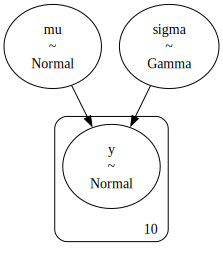

In [3]:
N = 10

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

In [4]:
pm.draw(mu)

array(0.54140207)

In [5]:
pm.draw(sigma, random_seed=rng)

array(0.66709727)

In [6]:
mu_value, sigma_value = pm.draw([mu, sigma], random_seed=rng)
mu_value, sigma_value

(array(-0.64551614), array(0.29948268))

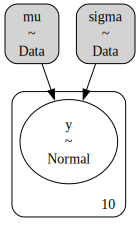

In [7]:
model_fixed_parameters = pm.do(model, {"mu": mu_value, "sigma": sigma_value})
model_fixed_parameters.to_graphviz()

In [8]:
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)
y_values

array([-0.93216552, -0.37497902,  0.02807845, -0.53793148, -0.99724182,
       -0.77754811, -0.60105837, -0.34428665, -0.63623636, -0.66625698])

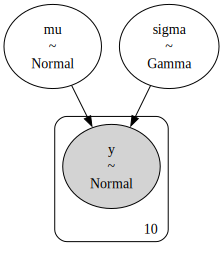

In [9]:
model_observed_data = pm.observe(model, {"y": y_values})
model_observed_data.to_graphviz()

In [10]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


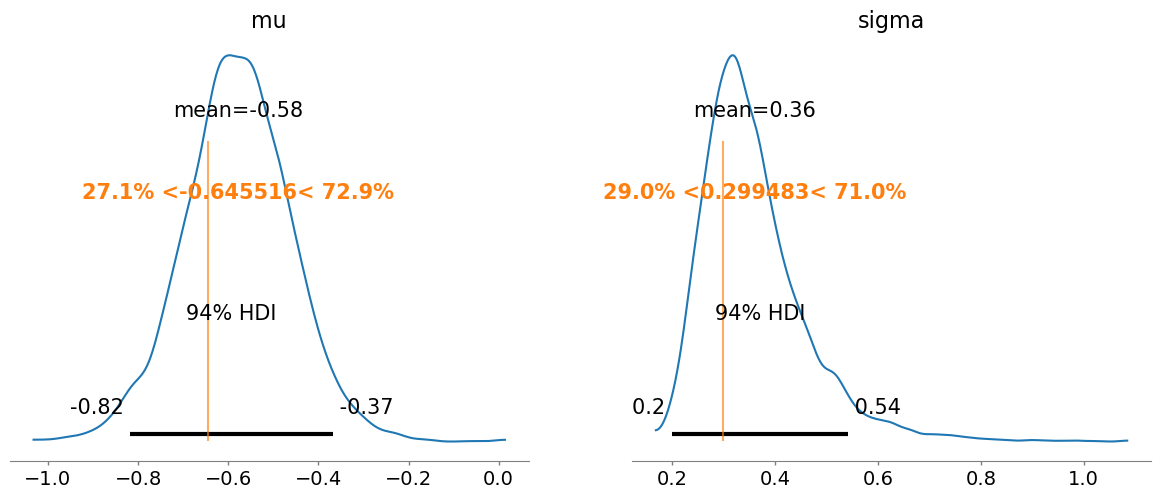

In [11]:
az.plot_posterior(idata, ref_val=[mu_value, sigma_value]);

## Simple linear regression

$$
\begin{aligned}
Y_i \mid \mu_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha + \beta x_i \\
\alpha &\sim \text{Normal}(0, 1^2) \\
\beta &\sim \text{Normal}(0, 1^2) \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$

### Known covariate values

In [12]:
x_values = np.array(
    [
        0.786, -0.399,  1.018,  0.657, -0.195, -0.083,  0.651, -0.476, -0.584, -0.194,
        0.282,  0.176, -0.309,  2.022,  0.341, -0.982, -0.904,  0.491, -2.07 , -0.568
    ]
)

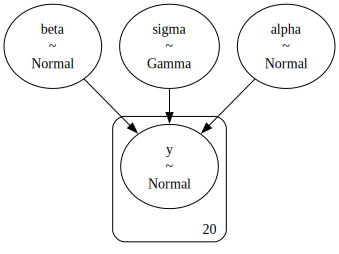

In [13]:
N = 20

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)

    mu = alpha + beta * x_values
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

In [14]:
alpha_value, beta_value, sigma_value = pm.draw([alpha, beta, sigma], random_seed=rng)

alpha_value, beta_value, sigma_value

(array(0.65595539), array(-0.28185848), array(2.95962304))

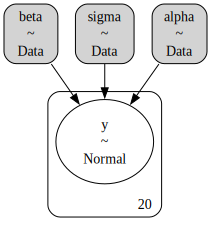

In [15]:
model_fixed_parameters = pm.do(
    model,
    {"alpha": alpha_value, "beta": beta_value, "sigma": sigma_value}
)

model_fixed_parameters.to_graphviz()

In [16]:
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)
y_values

array([ 3.12686173, -0.11044308, -4.05742728,  2.9712478 ,  1.03231454,
       -0.77103352,  0.42986971,  2.32298661,  2.22334492,  4.25858143,
       -1.75237172, -0.51776157,  3.27740227,  1.12482262, -4.2394528 ,
        0.77089266,  4.45871827,  5.20353471,  0.61391209,  3.22912347])

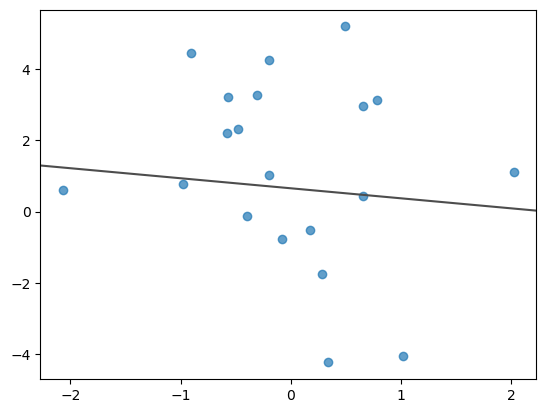

In [17]:
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3");

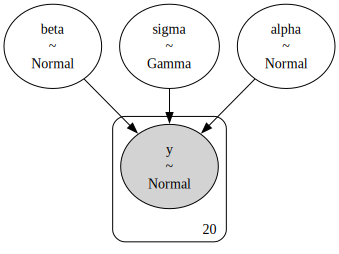

In [18]:
model_observed_data = pm.observe(model, {"y": y_values})
model_observed_data.to_graphviz()

In [19]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


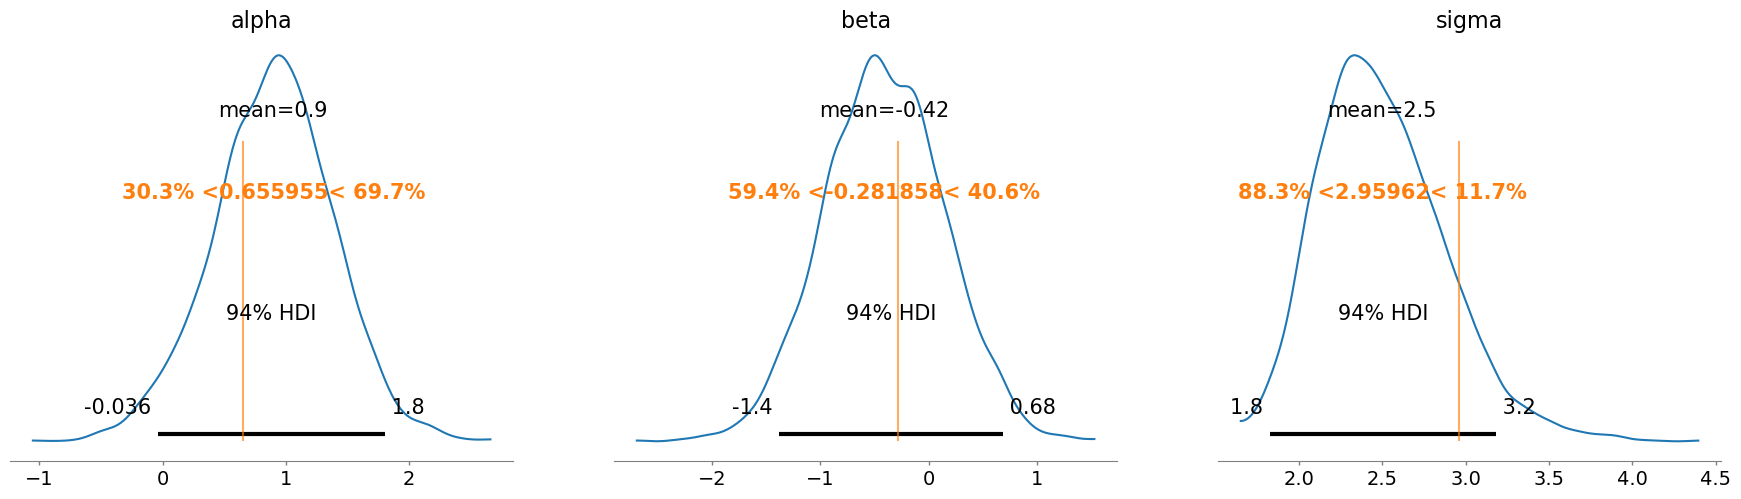

In [20]:
az.plot_posterior(idata, ref_val=[alpha_value, beta_value, sigma_value]);

In [21]:
posterior_draws = az.extract(
    idata, group="posterior", var_names=["alpha", "beta"], num_samples=15
)
posterior_draws

<xarray.Dataset> Size: 600B
Dimensions:  (sample: 15)
Coordinates:
  * sample   (sample) object 120B MultiIndex
  * chain    (sample) int64 120B 0 1 3 0 2 3 2 3 1 0 1 2 1 1 2
  * draw     (sample) int64 120B 387 347 604 772 844 998 ... 352 729 998 266 783
Data variables:
    alpha    (sample) float64 120B 0.1989 0.02191 0.7582 ... 1.258 0.8952 0.7909
    beta     (sample) float64 120B 1.006 -0.1302 -0.09987 ... -1.298 -1.072
Attributes:
    created_at:                 2024-11-01T15:01:02.675609+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.17.0
    sampling_time:              1.5686860084533691
    tuning_steps:               1000

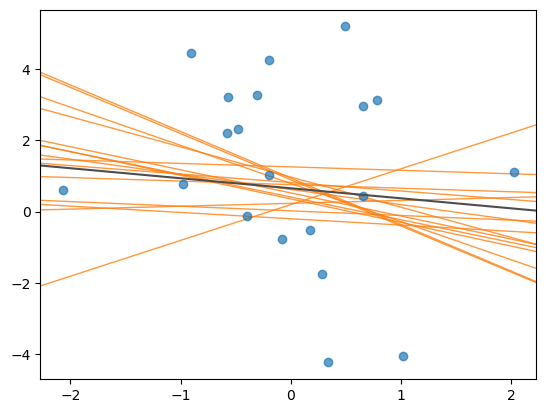

In [22]:
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3")

for a, b in zip(posterior_draws["alpha"].to_numpy(), posterior_draws["beta"].to_numpy()):
    ax.axline((0, a), slope=b, color="C1", alpha=0.8, lw=1, zorder=-1)

### Unknown covariate values

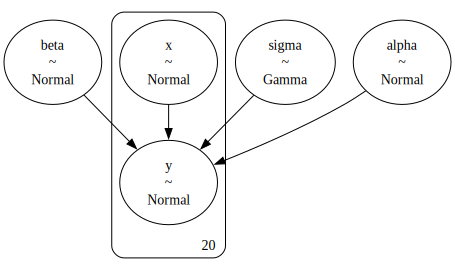

In [23]:
N = 20

with pm.Model() as model:
    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")
    x = pm.Normal("x", shape=N)

    mu = alpha + beta * x
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

In [24]:
alpha_value, beta_value, sigma_value, x_values = pm.draw([alpha, beta, sigma, x], random_seed=rng)

In [25]:
alpha_value, beta_value, sigma_value

(array(0.1719973), array(0.60085242), array(1.13516571))

In [26]:
x_values

array([-0.07292669, -0.54826599, -0.46954908,  0.26994204,  1.00053203,
        0.65220785, -1.52515351,  0.51970338, -0.51429822, -0.26137883,
       -0.47653569,  0.16923646, -0.93059417,  0.45502837, -1.05738506,
       -0.61663942, -0.52632527,  0.34543959, -0.04647066,  1.32000584])

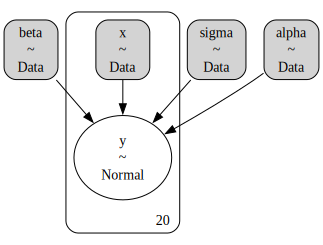

In [27]:
model_fixed_parameters = pm.do(
    model,
    {"alpha": alpha_value, "beta": beta_value, "sigma": sigma_value, "x": x_values}
)
model_fixed_parameters.to_graphviz()

In [28]:
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)
y_values

array([ 1.71790428, -0.0682522 , -1.26126753, -0.9484205 , -0.06096033,
        0.28471004, -0.40986102,  0.38968251, -2.03112939,  1.44298618,
        0.99584892, -0.46963706,  0.99470417,  0.2107016 ,  0.50460528,
       -0.72376308,  1.58806132,  0.28525278,  0.71371689,  2.99055351])

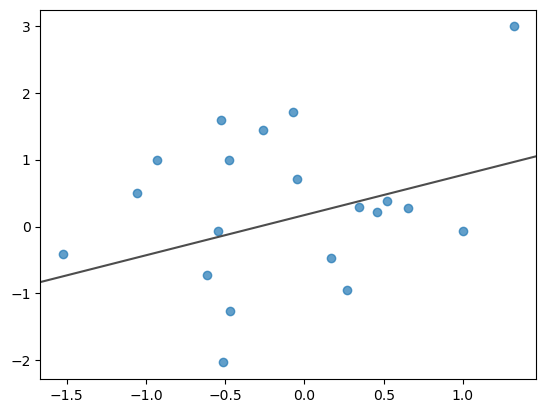

In [29]:
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3");

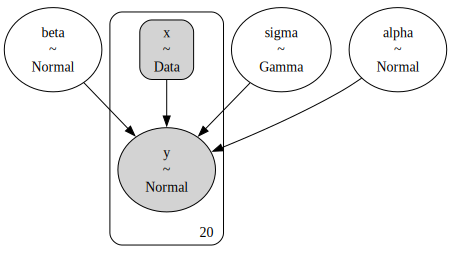

In [30]:
model_observed_data = pm.observe(pm.do(model, {"x": x_values}), {"y": y_values})
model_observed_data.to_graphviz()

In [31]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


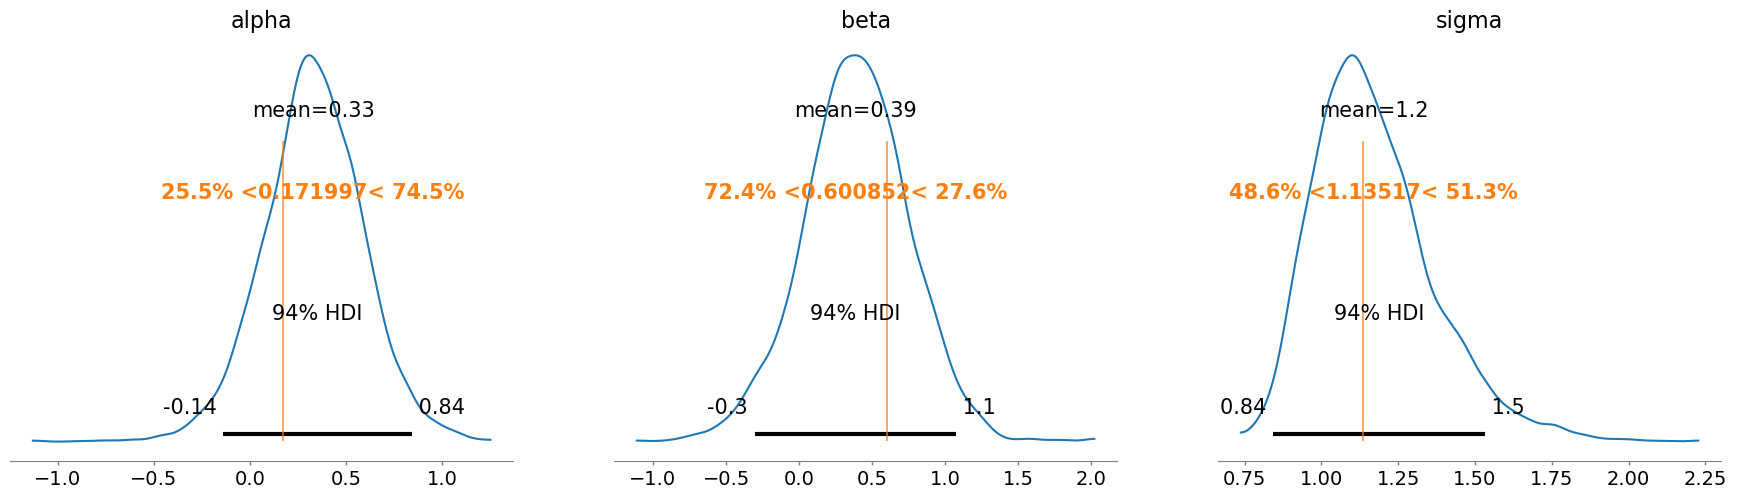

In [32]:
az.plot_posterior(idata, ref_val=[alpha_value, beta_value, sigma_value]);

In [33]:
posterior_draws = az.extract(
    idata, group="posterior", var_names=["alpha", "beta"], num_samples=15
)
posterior_draws

<xarray.Dataset> Size: 600B
Dimensions:  (sample: 15)
Coordinates:
  * sample   (sample) object 120B MultiIndex
  * chain    (sample) int64 120B 2 2 2 0 1 3 3 0 3 2 0 3 3 3 1
  * draw     (sample) int64 120B 72 334 363 200 777 83 ... 441 561 200 907 140
Data variables:
    alpha    (sample) float64 120B 0.1868 0.4576 0.5601 ... 0.0483 0.5178
    beta     (sample) float64 120B 0.3597 0.3973 0.6949 ... -0.191 0.5113 1.121
Attributes:
    created_at:                 2024-11-01T15:01:09.342150+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.17.0
    sampling_time:              1.5882854461669922
    tuning_steps:               1000

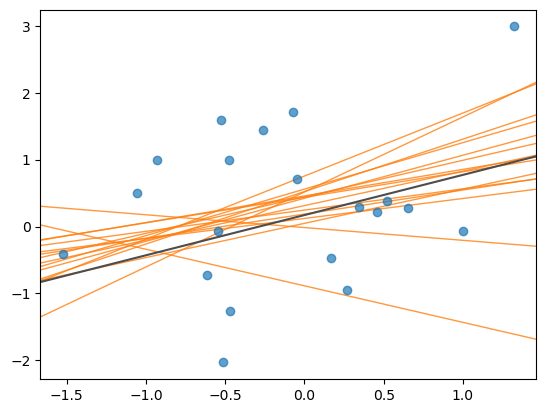

In [34]:
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, alpha=0.7)
ax.axline((0, alpha_value), slope=beta_value, color="0.3")

for a, b in zip(posterior_draws["alpha"].to_numpy(), posterior_draws["beta"].to_numpy()):
    ax.axline((0, a), slope=b, color="C1", alpha=0.8, lw=1, zorder=-1)

## Normal model for multiple groups

$$
\begin{aligned}
Y_i     &\sim \text{Normal}(\mu_{j[i]}, \sigma^2) \\
\mu_j &\sim \text{Normal}(0, 3^2) & \text{for all } j \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$ and $j = 1, \dots, J$.

The indexing notation in $\mu_{j[i]}$ is read as "the value of $j$ for the $i$-th observation". You can also see $j[i]$ as a function call, where you pass the index of an observation and it gives you the value of the group it belongs to.

### Known group membership

Let's start with a simple example, where:

* All groups have the same, pre-defined, sample size.
* Group memberships are known.
* Observations are sorted by group.

In [35]:
J = 4        # Number of groups
n_j = 20     # Number of observations per group
N = J * n_j  # Total number of observations

# Generate group indexes
group_idx = np.repeat(np.arange(J), n_j)
print("Group indexes:")
print(group_idx)

Group indexes:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


The first 20 observations are from the first group, the second 20 observations are from the second group, and so on.

Let's write the model in PyMC. Since we have as many means as groups, we need to pass `shape=J` when we define the prior for $\mu$.

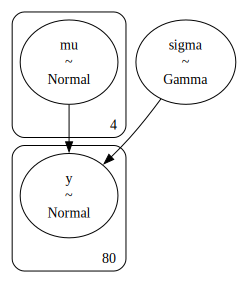

In [36]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=3, shape=J)
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    mu_indexed = mu[group_idx]
    pm.Normal("y", mu=mu_indexed, sigma=sigma, shape=N)

model.to_graphviz()

Notice we didn't register `group_idx` using a `pm.Data` container. This is not needed, just recommended.

In [37]:
mu_values, mu_indexed_values, sigma_value = pm.draw([mu, mu_indexed, sigma], random_seed=rng)
print("mu:", mu_values)
print("sigma:", sigma_value)

mu: [6.05496819 1.16678048 2.30070048 4.72798215]
sigma: 0.5873507289564738


In [38]:
mu_indexed_values

array([6.05496819, 6.05496819, 6.05496819, 6.05496819, 6.05496819,
       6.05496819, 6.05496819, 6.05496819, 6.05496819, 6.05496819,
       6.05496819, 6.05496819, 6.05496819, 6.05496819, 6.05496819,
       6.05496819, 6.05496819, 6.05496819, 6.05496819, 6.05496819,
       1.16678048, 1.16678048, 1.16678048, 1.16678048, 1.16678048,
       1.16678048, 1.16678048, 1.16678048, 1.16678048, 1.16678048,
       1.16678048, 1.16678048, 1.16678048, 1.16678048, 1.16678048,
       1.16678048, 1.16678048, 1.16678048, 1.16678048, 1.16678048,
       2.30070048, 2.30070048, 2.30070048, 2.30070048, 2.30070048,
       2.30070048, 2.30070048, 2.30070048, 2.30070048, 2.30070048,
       2.30070048, 2.30070048, 2.30070048, 2.30070048, 2.30070048,
       2.30070048, 2.30070048, 2.30070048, 2.30070048, 2.30070048,
       4.72798215, 4.72798215, 4.72798215, 4.72798215, 4.72798215,
       4.72798215, 4.72798215, 4.72798215, 4.72798215, 4.72798215,
       4.72798215, 4.72798215, 4.72798215, 4.72798215, 4.72798

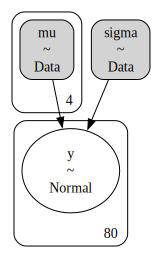

In [39]:
model_fixed_parameters = pm.do(model, {"mu": mu_values, "sigma": sigma_value})
model_fixed_parameters.to_graphviz()

In [40]:
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)
y_values

array([ 5.96848962,  5.41773617,  5.97582542,  6.16600045,  5.82297508,
        4.48224291,  6.95819834,  6.47957867,  6.5820155 ,  6.33724219,
        6.7852352 ,  5.46279953,  5.56506722,  6.56812127,  4.86342814,
        5.42240248,  5.83728826,  5.48595091,  5.2691634 ,  7.28122347,
        1.71587604, -0.3876235 ,  1.41955656,  1.42647302,  0.36667179,
        1.52519163,  0.56187569,  0.95782797,  0.59472296,  1.20774447,
        0.92033241,  1.49061858,  0.5213975 ,  0.93198674,  1.21275358,
        0.98559703,  1.53253938,  0.56249955,  1.1544688 ,  1.9230985 ,
        2.16199016,  1.53042959,  3.19265599,  3.47870745,  2.39604538,
        2.42807734,  2.33642177,  2.35176928,  3.12210895,  2.83377131,
        2.93477609,  3.29931115,  2.26916874,  3.53382039,  1.70797709,
        1.68041215,  1.6469546 ,  3.22415714,  3.05394628,  4.11746884,
        4.08738601,  4.77478635,  4.65323298,  4.20329442,  4.26795213,
        5.15047315,  4.07147009,  4.8377443 ,  4.3639377 ,  4.59

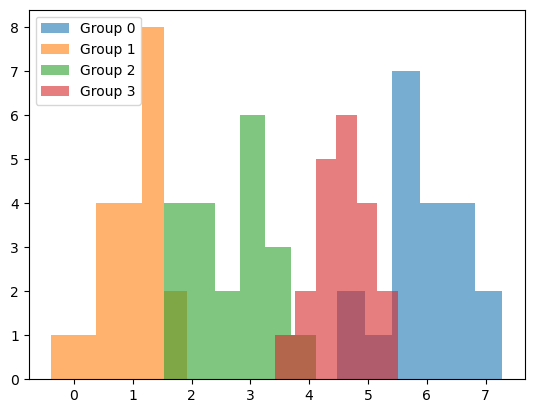

In [41]:
fig, ax = plt.subplots()

for j in range(J):
    ax.hist(y_values[group_idx == j], bins=6, alpha=0.6, label=f"Group {j}")
ax.legend();

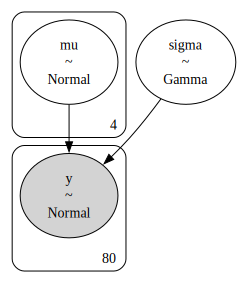

In [42]:
model_observed_data = pm.observe(model, {"y": y_values})
model_observed_data.to_graphviz()

In [43]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


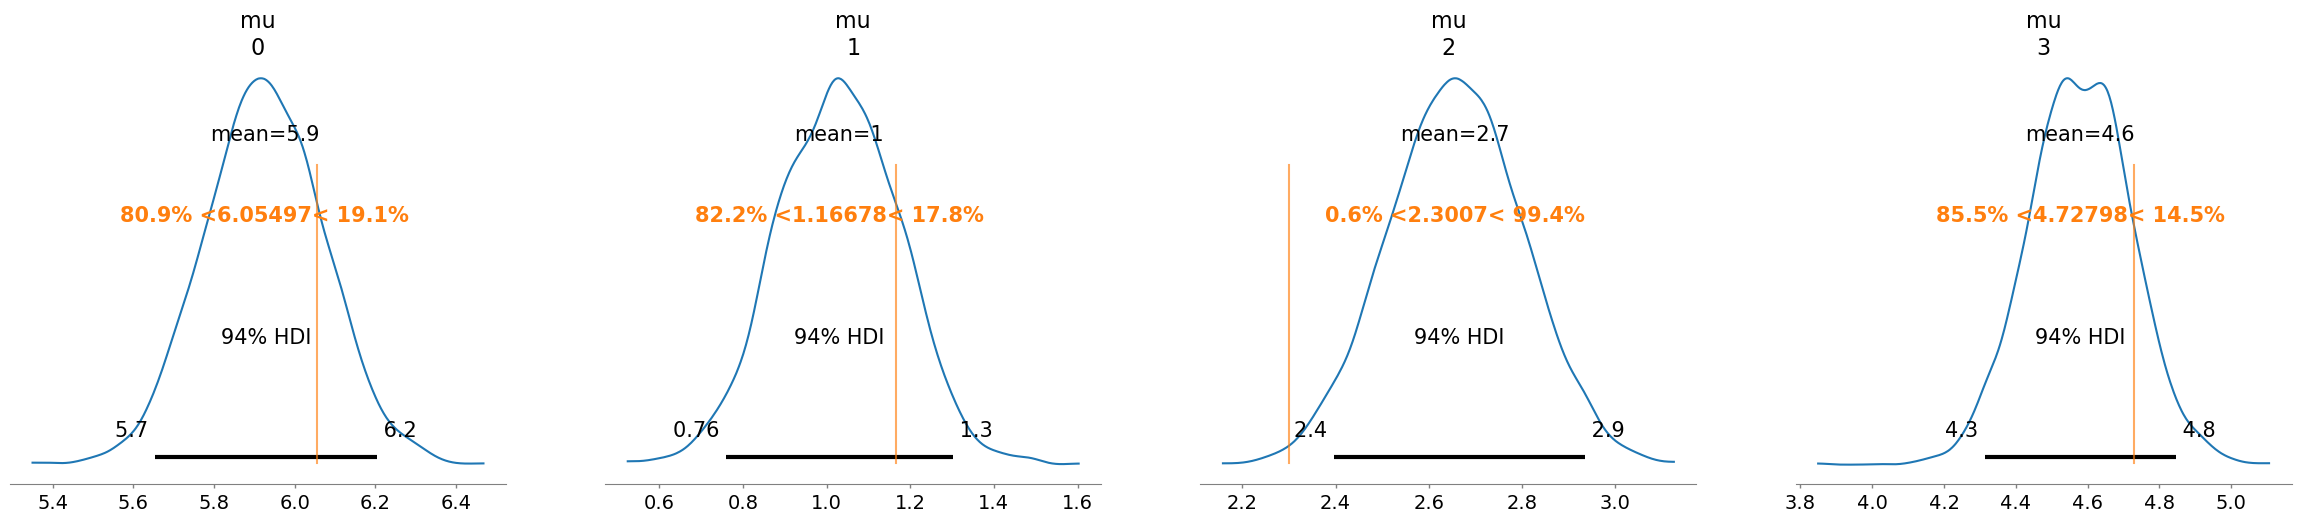

In [44]:
az.plot_posterior(idata, var_names=["mu"], ref_val=mu_values.tolist());

In [45]:
with model_observed_data:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [y]


Output()

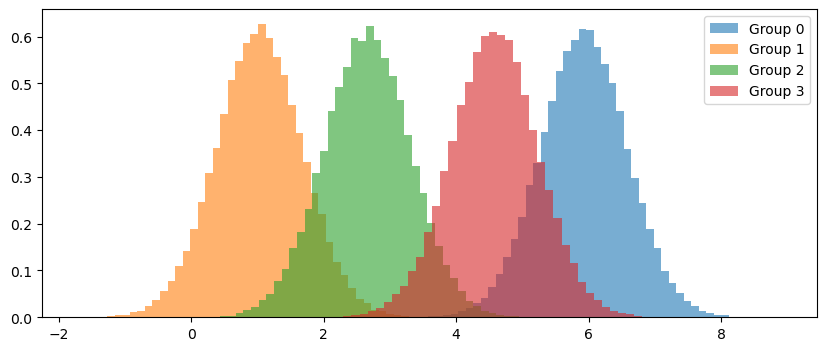

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))

for j in range(J):
    predictive_values = idata.posterior_predictive["y"].to_numpy()[..., group_idx == j].flatten()
    ax.hist(predictive_values, bins=50, alpha=0.6, label=f"Group {j}", density=True)
ax.legend();

### Unknown group membership

$$
\begin{aligned}
Y_i     &\sim \text{Normal}(\mu_{j[i]}, \sigma^2) \\
\mu_j &\sim \text{Normal}(0, 3^2) & \text{for all } j \\
\sigma  &\sim \text{Gamma}(2, 2)
\end{aligned}
$$

with $i = 1, \dots, N$ and $j = 1, \dots, J$.

The model is exactly the same as the one in the previous section. The difference is that we don't know how many observations belong to each group -- we also want to simulate that.

To simulate group memberships we need a distribution that gives us integers between $0$ and $J-1$. One such distribution is the discrete uniform distribution.

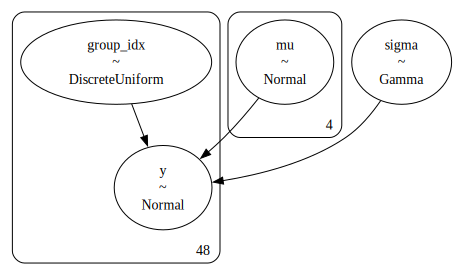

In [47]:
J = 4    # Number of groups
N = 48   # Total number of observations

with pm.Model() as model:
    group_idx = pm.DiscreteUniform("group_idx", lower=0, upper=J-1, shape=N)
    mu = pm.Normal("mu", mu=0, sigma=3, shape=J)
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    pm.Normal("y", mu=mu[group_idx], sigma=sigma, shape=N)

model.to_graphviz()

In [48]:
mu_values, sigma_value, group_idx_values = pm.draw([mu, sigma, group_idx], random_seed=rng)

In [49]:
print("mu:", mu_values, "| sigma:", sigma_value)
print("group indexes:\n", group_idx_values)

mu: [ 4.39222186  3.06006526 -1.82575653  3.42869414] | sigma: 0.36418924500311767
group indexes:
 [2 0 0 2 1 3 2 0 2 2 3 3 3 3 3 0 3 0 3 3 3 0 3 1 2 2 1 2 2 0 3 0 3 2 3 0 0
 0 1 0 1 0 0 2 0 0 2 3]


In [50]:
np.unique(group_idx_values, return_counts=True)[1]

array([16,  5, 12, 15])

All the rest is exactly the same.

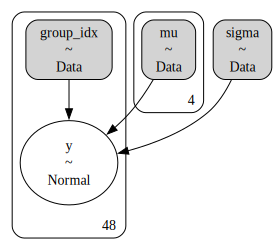

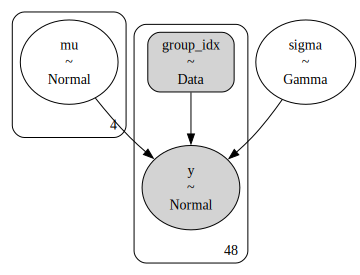

In [51]:
# Fix model parameters _and_ data
model_fixed_parameters = pm.do(
    model,
    {"mu": mu_values, "sigma": sigma_value, "group_idx": group_idx_values}
)

# Display model graph
display(model_fixed_parameters.to_graphviz())

# Simulate values from the outcome
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Observe the outcome values
model_observed_data = pm.observe(
    pm.do(model, {"group_idx": group_idx_values}),
    {"y": y_values}
)

display(model_observed_data.to_graphviz())

## Good practices

### Use `pm.Data` containers to register data variables

In [52]:
x_values = np.array(
    [
        0.786, -0.399,  1.018,  0.657, -0.195, -0.083,  0.651, -0.476, -0.584, -0.194,
        0.282,  0.176, -0.309,  2.022,  0.341, -0.982, -0.904,  0.491, -2.07 , -0.568
    ]
)

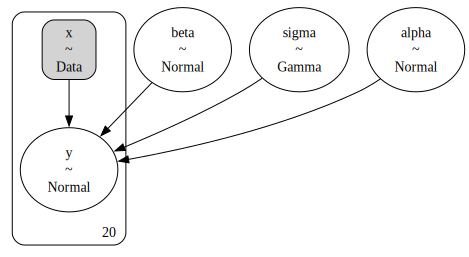

In [53]:
N = 20

with pm.Model() as model:
    x_data = pm.Data("x", value=x_values)

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")
    mu = alpha + beta * x_data
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, shape=N)

model.to_graphviz()

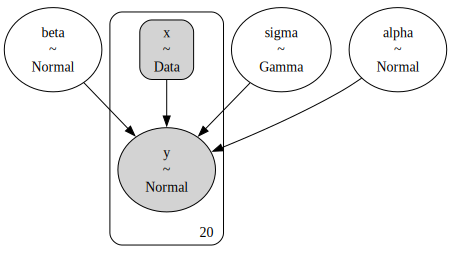

In [54]:
# Simulate values for the parameters
alpha_value, beta_value, sigma_value = pm.draw([alpha, beta, sigma], random_seed=rng)

# Fix parameter values in the mdoel
model_fixed_parameters = pm.do(
    model,
    {"alpha": alpha_value, "beta": beta_value, "sigma": sigma_value}
)

# Simulate values for the outcome variable
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Set the outcome values as observed in the original model
model_observed_data = pm.observe(model, {"y": y_values})

# Visualize graph
model_observed_data.to_graphviz()

### Use `coords` and `dims`

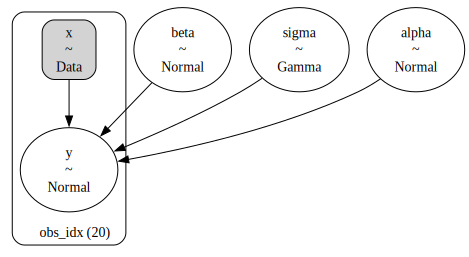

In [55]:
N = 20

coords = {
    "obs_idx": np.arange(N)
}

with pm.Model(coords=coords) as model:
    x_data = pm.Data("x", value=x_values, dims="obs_idx")

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta")
    mu = alpha + beta * x_data
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    pm.Normal("y", mu=mu, sigma=sigma, dims="obs_idx")

model.to_graphviz()

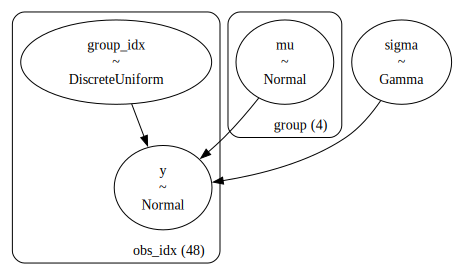

In [56]:
J = 4    # Number of groups
N = 48   # Total number of observations

coords = {
    "group": ["Group 1", "Group 2", "Group 3", "Group 4"],
    "obs_idx": np.arange(N)
}

with pm.Model(coords=coords) as model:
    group_idx = pm.DiscreteUniform("group_idx", lower=0, upper=J-1, dims="obs_idx")
    mu = pm.Normal("mu", mu=0, sigma=3, dims="group")
    sigma = pm.Gamma("sigma", alpha=2, beta=2)
    pm.Normal("y", mu=mu[group_idx], sigma=sigma, dims="obs_idx")

model.to_graphviz()

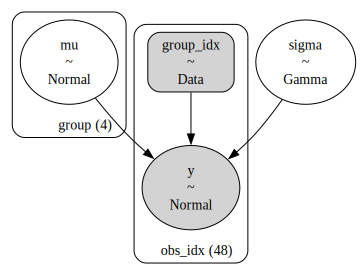

In [57]:
mu_values, sigma_value, group_idx_values = pm.draw([mu, sigma, group_idx], random_seed=rng)

# Fix model parameters _and_ data
model_fixed_parameters = pm.do(
    model,
    {"mu": mu_values, "sigma": sigma_value, "group_idx": group_idx_values}
)

# Simulate values from the outcome
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Observe the outcome values
model_observed_data = pm.observe(
    pm.do(model, {"group_idx": group_idx_values}),
    {"y": y_values}
)

model_observed_data.to_graphviz()

In [58]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [59]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu[Group 1],0.388,0.189,0.028,0.736
mu[Group 2],-3.817,0.150,-4.105,-3.550
mu[Group 3],-3.890,0.157,-4.173,-3.580
mu[Group 4],3.016,0.172,2.680,3.333
sigma,0.568,0.062,0.453,0.681


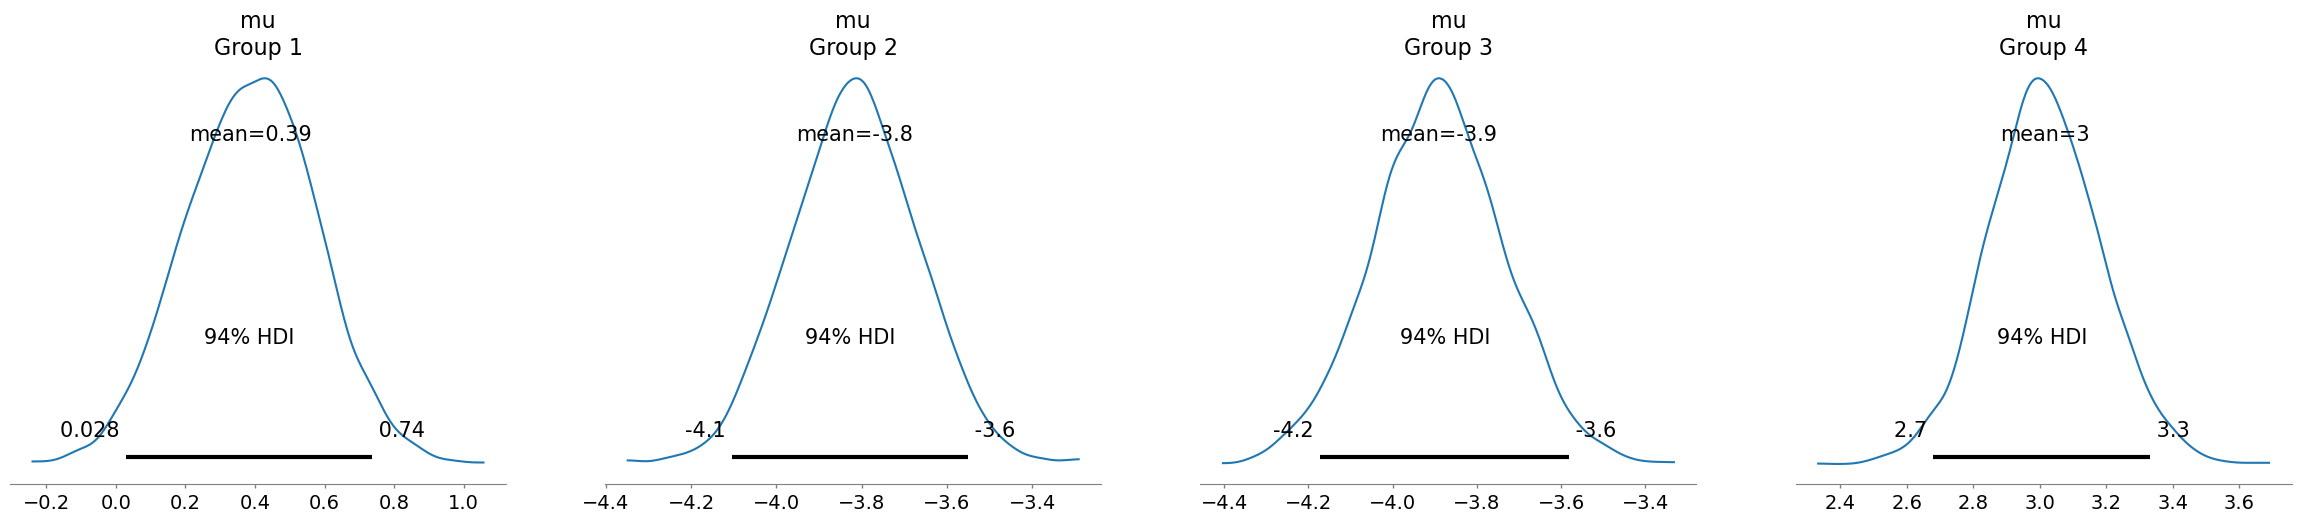

In [60]:
az.plot_posterior(idata, var_names="mu");

In [61]:
idata.posterior["mu"].sel(group="Group 3")

<xarray.DataArray 'mu' (chain: 4, draw: 1000)> Size: 32kB
array([[-4.03705149, -3.78900314, -3.76479051, ..., -4.04628137,
        -3.88638045, -4.21007427],
       [-3.74006981, -4.03929702, -4.01893038, ..., -3.92875527,
        -3.76260604, -4.02621378],
       [-3.77833314, -3.85270145, -3.86176492, ..., -3.76218849,
        -3.93732774, -3.91962555],
       [-4.25014046, -3.70552177, -3.99825767, ..., -3.76144302,
        -3.61515607, -3.93889675]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    group    <U7 28B 'Group 3'

## Advanced example

### Initial attempt

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\pi_i & = \text{expit}(\alpha_{j[i]} + \beta_{j[i]} \times \text{age}_i) \\
\alpha_j &\sim \text{Normal}(0, 0.5^2) & \text{for all } j \\
\beta_j &\sim \text{Normal}(0, 0.5^2) & \text{for all } j \\
\end{aligned}
$$

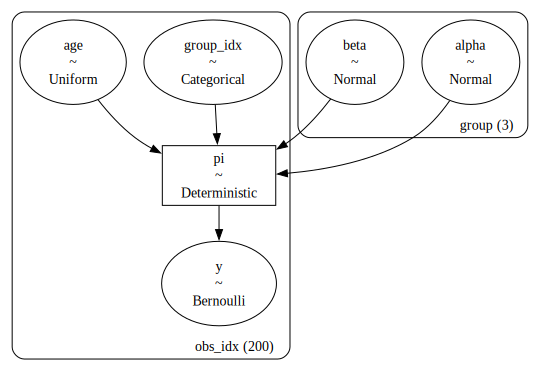

In [62]:
J = 3
p = [0.5, 0.3, 0.2]
N = 200

coords = {
    "group": ["A", "B", "C"],
    "obs_idx": np.arange(N)
}

with pm.Model(coords=coords) as model:
    age = pm.Uniform("age", lower=16, upper=70, dims="obs_idx")
    group_idx = pm.Categorical("group_idx", p=p, dims="obs_idx")

    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="group")
    beta = pm.Normal("beta", mu=0, sigma=1, dims="group")

    pi = pm.Deterministic(
        "pi",
        pm.math.sigmoid(alpha[group_idx] + beta[group_idx] * age),
        dims="obs_idx"
    )

    pm.Bernoulli("y", p=pi, dims="obs_idx")

model.to_graphviz()

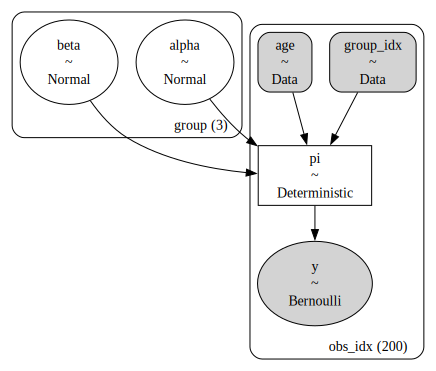

In [63]:
alpha_values, beta_values, age_values, group_idx_values = pm.draw(
    [alpha, beta, age, group_idx],
    random_seed=rng
)

# Fix model parameters _and_ data
model_fixed_parameters = pm.do(
    model,
    {
        "alpha": alpha_values,
        "beta": beta_values,
        "age": age_values,
        "group_idx": group_idx_values
    }
)

# Simulate values from the outcome
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Observe the outcome values
model_observed_data = pm.observe(
    pm.do(model, {"age": age_values, "group_idx": group_idx_values}),
    {"y": y_values}
)

model_observed_data.to_graphviz()

In [64]:
print("alpha:", alpha_values)
print("beta:", beta_values)

alpha: [0.47438197 0.20107513 1.36161128]
beta: [ 0.3889577  -1.65269511  2.58244597]


In [65]:
np.unique(group_idx_values, return_counts=True)

(array([0, 1, 2]), array([98, 58, 44]))

In [66]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 3306 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Taking the covariate scale into account

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\pi_i & = \text{expit}(\alpha_{j[i]} + \beta_{j[i]} \times \text{age}^*_i \\
\alpha_j &\sim \text{Normal}(0, 0.5^2) & \text{for all } j \\
\beta_j &\sim \text{Normal}(0, 0.5^2) & \text{for all } j \\
\end{aligned}
$$

where

$$
\text{age}^*_i = \frac{\text{age}_i - \text{mean}(\text{age})}{\text{std}(\text{age})}
$$

In [67]:
import pytensor.tensor as pt

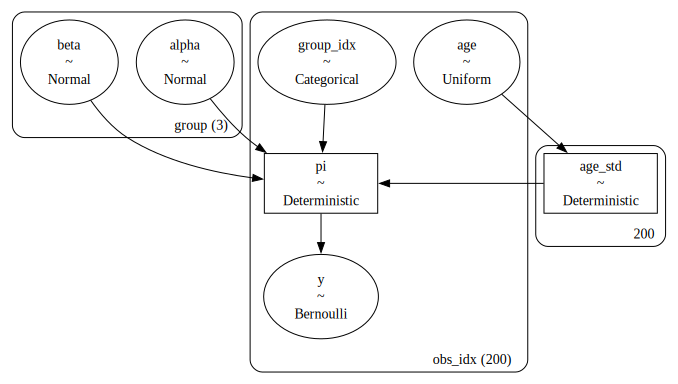

In [68]:
J = 3
p = [0.5, 0.3, 0.2]
N = 200

coords = {
    "group": ["A", "B", "C"],
    "obs_idx": np.arange(N)
}

with pm.Model(coords=coords) as model:
    age = pm.Uniform("age", lower=16, upper=70, dims="obs_idx")
    group_idx = pm.Categorical("group_idx", p=p, dims="obs_idx")

    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="group")
    beta = pm.Normal("beta", mu=0, sigma=1, dims="group")

    age_std = pm.Deterministic(
        "age_std",
        (age - pt.mean(age)) / pt.std(age)
    )

    pi = pm.Deterministic(
        "pi",
        pm.math.sigmoid(alpha[group_idx] + beta[group_idx] * age_std),
        dims="obs_idx"
    )

    pm.Bernoulli("y", p=pi, dims="obs_idx")

model.to_graphviz()

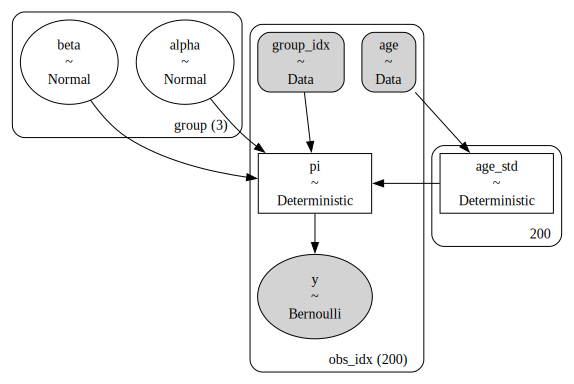

In [69]:
alpha_values, beta_values, age_values, group_idx_values = pm.draw(
    [alpha, beta, age, group_idx],
    random_seed=rng
)

# Fix model parameters and data
model_fixed_parameters = pm.do(
    model,
    {
        "alpha": alpha_values,
        "beta": beta_values,
        "age": age_values,
        "group_idx": group_idx_values
    }
)

# Simulate values from the outcome
y_values = pm.draw(model_fixed_parameters["y"], random_seed=rng)

# Observe the outcome values
model_observed_data = pm.observe(
    pm.do(model, {"age": age_values, "group_idx": group_idx_values}),
    {"y": y_values}
)

model_observed_data.to_graphviz()

In [70]:
with model_observed_data:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


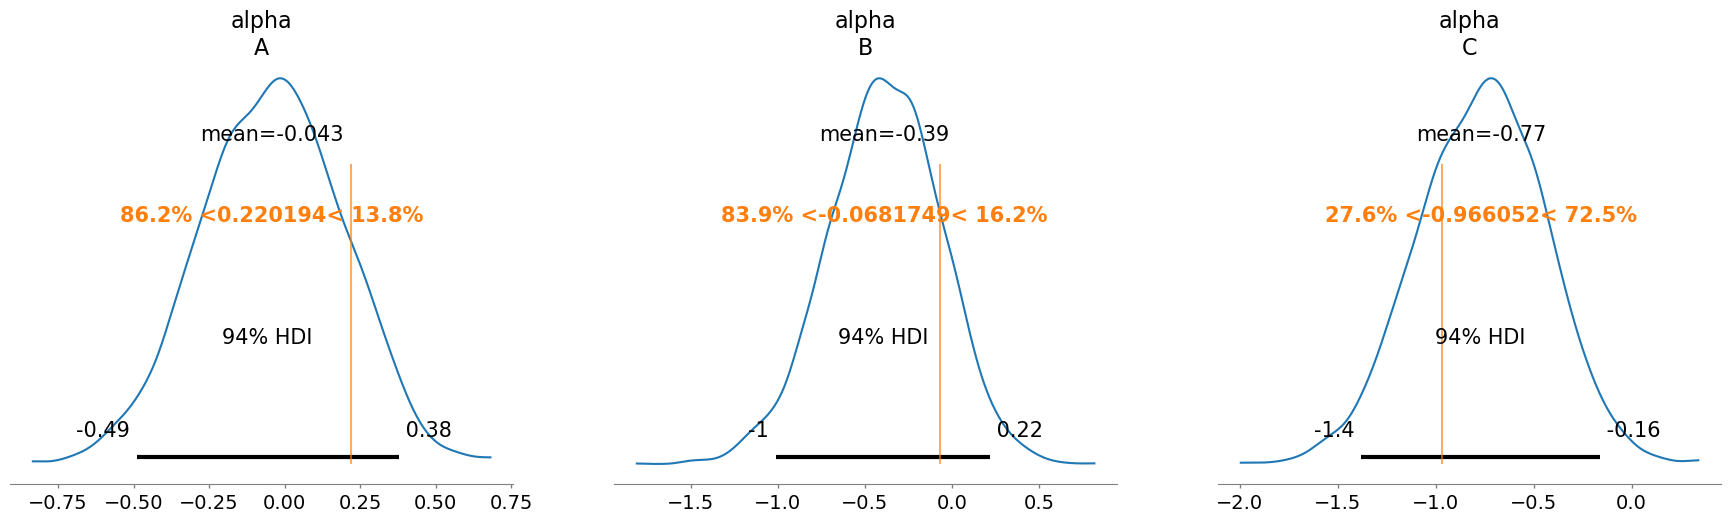

In [71]:
az.plot_posterior(idata, var_names="alpha", ref_val=alpha_values.tolist());

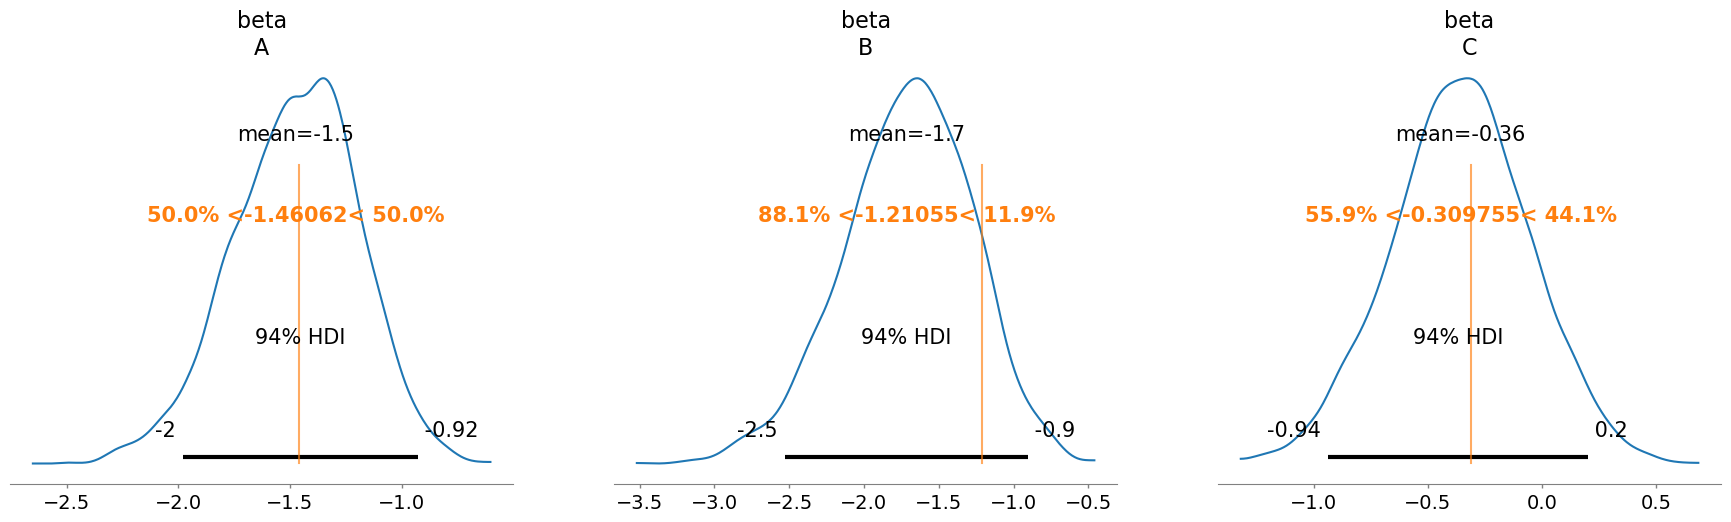

In [72]:
az.plot_posterior(idata, var_names="beta", ref_val=beta_values.tolist());

### Out of model predictions

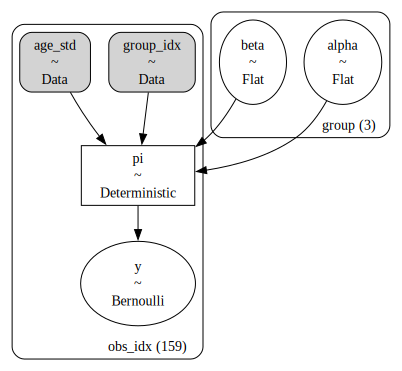

In [73]:
age_mean = np.mean(age_values)
age_std = np.std(age_values)

age_range = np.arange(18, 71)
age_values = np.tile(age_range, J)
group_idx = np.repeat(np.arange(J), len(age_range))

coords = {
    "group": ["A", "B", "C"],
    "obs_idx": np.arange(len(age_values))
}

with pm.Model(coords=coords) as model:
    age_data = pm.Data("age_std", (age_values - age_mean) / age_std, dims="obs_idx")
    group_idx_data = pm.Data("group_idx", group_idx, dims="obs_idx")

    alpha = pm.Flat("alpha", dims="group")
    beta = pm.Flat("beta", dims="group")

    pi = pm.Deterministic(
        "pi",
        pm.math.sigmoid(alpha[group_idx_data] + beta[group_idx_data] * age_data),
        dims="obs_idx"
    )

    pm.Bernoulli("y", p=pi, dims="obs_idx")

model.to_graphviz()

In [74]:
with model:
    predictions = pm.sample_posterior_predictive(
        idata, var_names=["pi"], predictions=True, random_seed=rng
    )["predictions"]

Sampling: []


Output()

In [75]:
pi_mean = predictions["pi"].mean(("chain", "draw"))
pi_lower, pi_upper = predictions["pi"].quantile((0.025, 0.975), ("chain", "draw"))

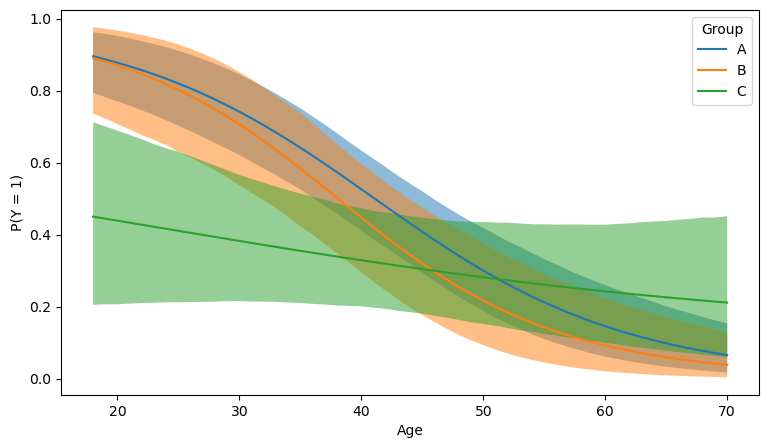

In [76]:
fig, ax = plt.subplots(figsize=(9, 5))

for j, group in enumerate(["A", "B", "C"]):
    ax.plot(age_range, pi_mean.sel(obs_idx=group_idx==j), label=group)
    ax.fill_between(
        age_range,
        pi_lower.sel(obs_idx=group_idx==j),
        pi_upper.sel(obs_idx=group_idx==j),
        alpha=0.5
    )

ax.legend(title="Group")
ax.set(xlabel="Age", ylabel="P(Y = 1)");